# Occupancy gridmap building

The goal of this optional project is to implement the needed functionality so a robot moving in an environment can build an occupancy gridmap of it.   

<figure style="text-align:center">
  <img src="utils/images/ExampleGrid.png" alt="">
    <figcaption><b>Fig. 1</b> - Occupancy Gridmap example.</figcaption>
</figure>


#### Project considerations:
- A 2D laser simulator is provided.
- The environment is defined with lines.
- Localization is known.
- In order to build the map, the robot has to move within it.

In [9]:
# Required libraries
import numpy as np
from numpy import array, sin, cos, pi
import matplotlib.pyplot as plt

# Modules provided
from laser.laser2D import Laser2D
from utils.tcomp import tcomp
from utils.DrawRobot import DrawRobot
from utils.bresenham import bresenham

## Initialization of the enviroment

In [16]:
# Define the environment
map = np.array([[0, 0, 4, 4, 6, 8, 10, 10, 8, 4, 4, 1, 0], 
                [4, 0, 0, 2, 2, 0, 0, 4, 6, 6, 5, 5, 4]])*1.5

# Create a grid representing the occupancy map
grid_resolution = 0.5
occupancy_map = np.zeros((15, 20), dtype=np.int32)

# Set robot pose
robot_pose = np.vstack([1., 1., np.pi/4]) #[x,y,theta]
inc_pose = np.vstack([1.5 ,0. ,-np.pi/24]) #[x,y,theta]
num_steps = 10

# Prepare the laser
FOV = 180 * np.pi/180 #radians
resolution = 10 * np.pi/180 #radians
max_distance = 10 #meters
noise_cov = np.array([[0.005, 0],[0, 0.0002]]) #covariance matrix
laser_pose = robot_pose #same than the robot

## Algorithm body

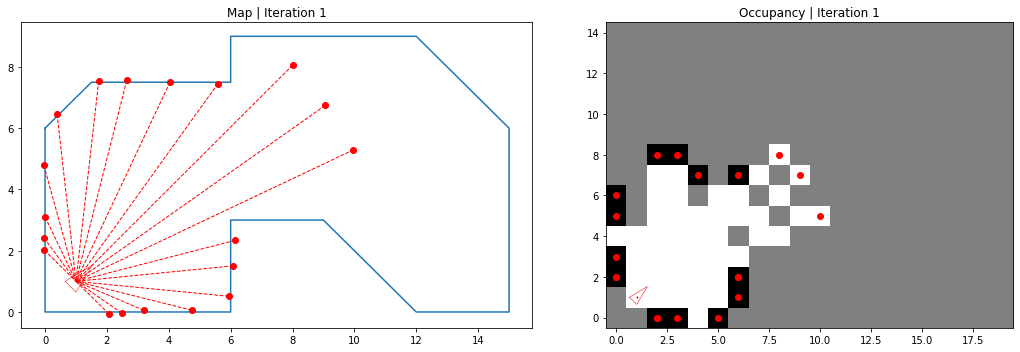

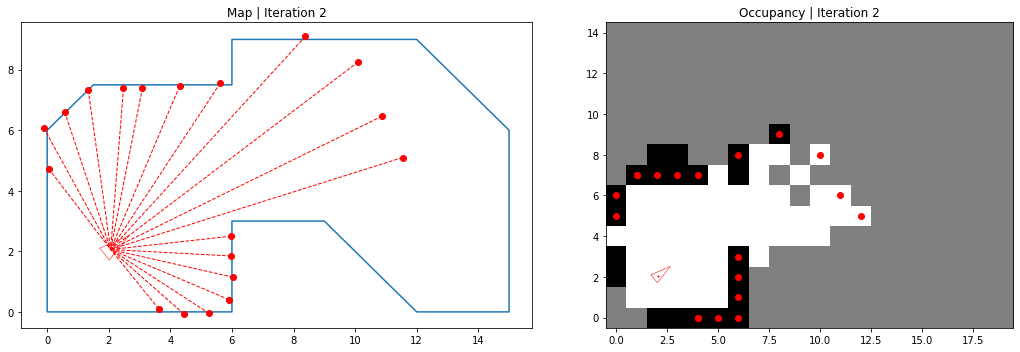

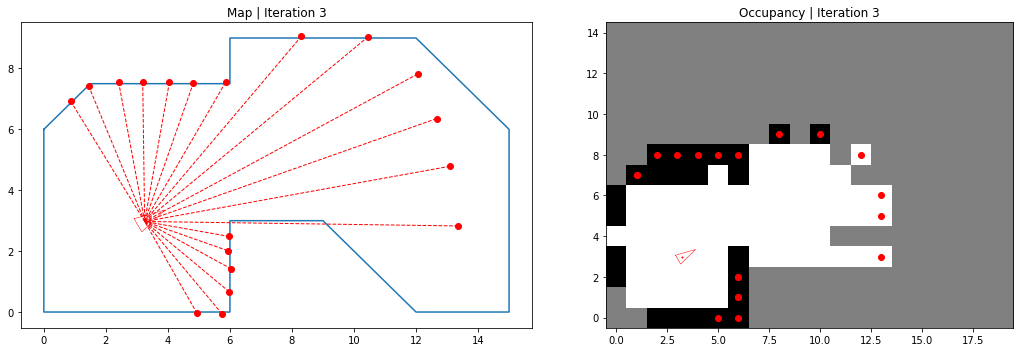

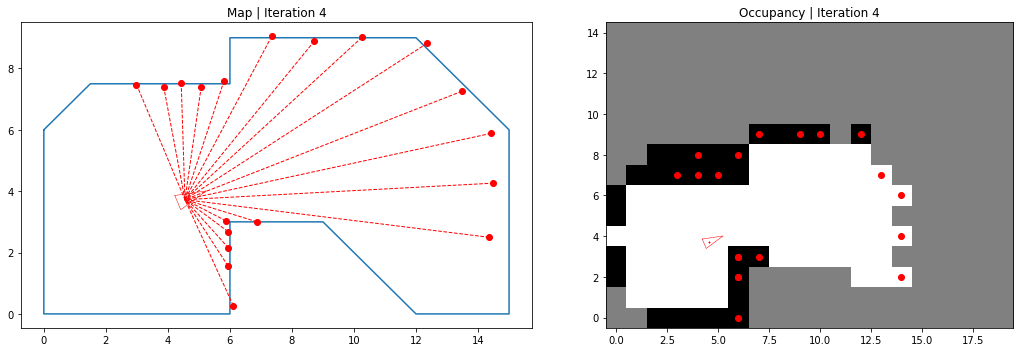

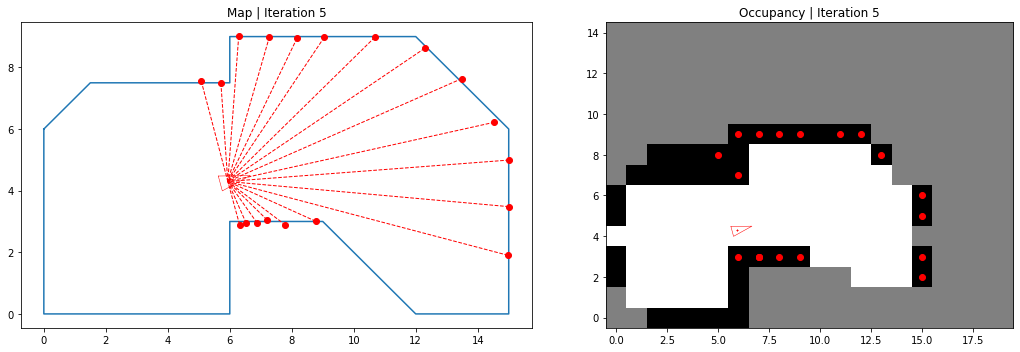

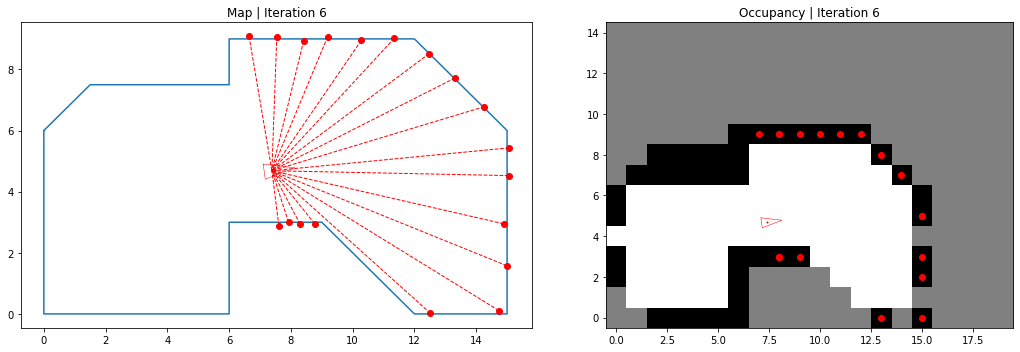

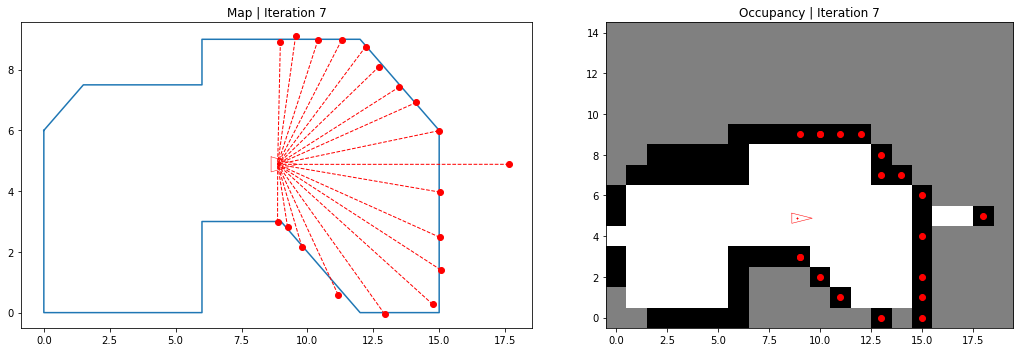

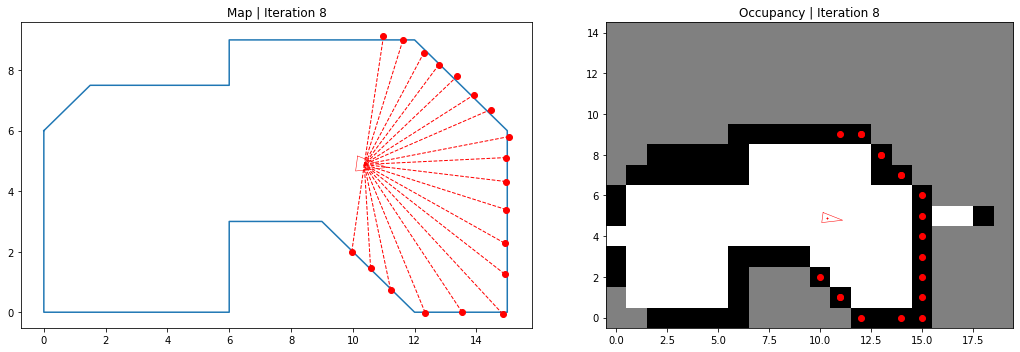

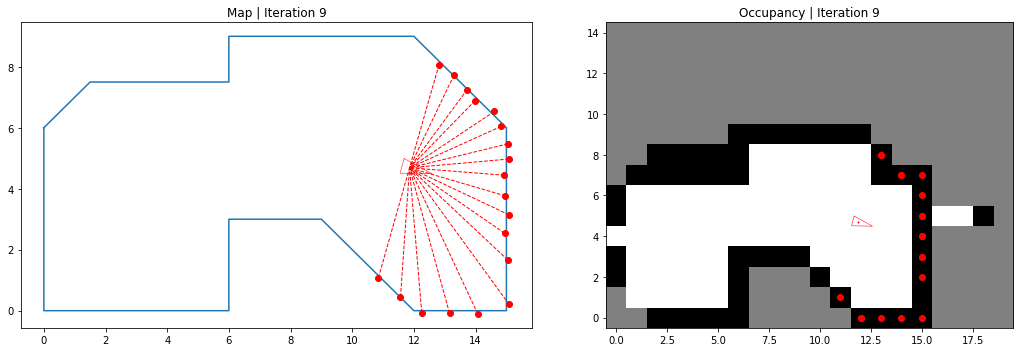

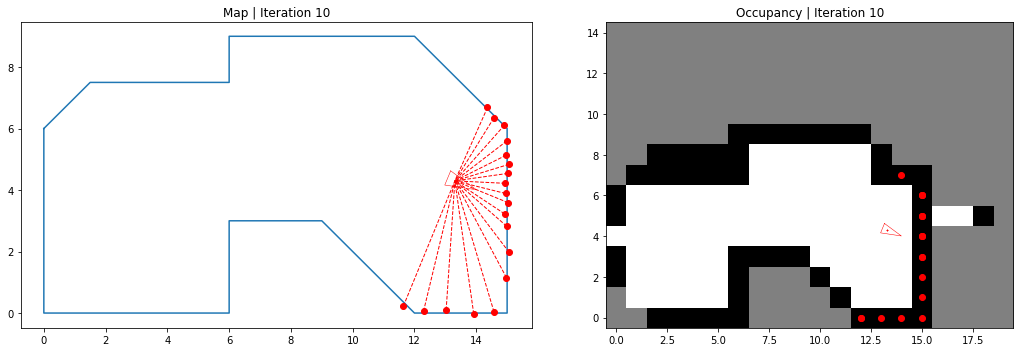

In [17]:
# Loop through the iterations
for step in range(1,num_steps+1):
    
    # Plot the map - Left axis (ax1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title("Map | Iteration " + str(step))
    ax1.plot(map[0,:],map[1,:])
    
    # Plot the robot pose
    DrawRobot(fig, ax1, robot_pose, axis_percent=0.25, color='red')
    DrawRobot(fig, ax2, robot_pose, axis_percent=0.25, color='red')

    # Take and draw the observations
    laser = Laser2D(FOV, resolution, max_distance, noise_cov, laser_pose)
    z = laser.take_observation(map)
    laser.draw_observation(z,laser_pose,fig,ax1)
    
    # Plot the occupancy map - Right axis (ax2)
    ax2.set_title("Occupancy | Iteration " + str(step))
    #ax2.plot(map[0,:],map[1,:])
    
    # Iterate through the observations
    for i in range (z.shape[1]):
      z_i = z[:,i] #current observation
      x = int(np.round(laser_pose[0]+z_i[0]*np.cos(z_i[1]+laser_pose[2])))
      y = int(np.round(laser_pose[1]+z_i[0]*np.sin(z_i[1]+laser_pose[2])))
      ax2.plot(x,y,'ro') #plot the red dots in the cell to update
        
      # Pose of the robot in the current iteration 
      x0 = int(np.round(laser_pose[0]))
      y0 = int(np.round(laser_pose[1]))
    
      # Fullfil the spaces between the robot and the walls with 1s
      path = bresenham(x0,y0,x,y)
      for (n,m) in path:
        if occupancy_map[m,n] != -1: #if not a wall...
            occupancy_map[m,n] = 1 #...mark as empty

      if np.round(z_i[0]) != max_distance: #if not farther from max_dist...
          occupancy_map[y,x] = -1 #...it must be an obstacle in the way
    
    # Plot after the iteration update
    ax2.imshow(occupancy_map, cmap='gray', origin='lower')
    
    # Update pose after movement
    robot_pose = tcomp(robot_pose, inc_pose)
    laser_pose = robot_pose
    
    # Adjust to the limits
    plt.tight_layout()
    plt.show()

## Interesting conclusions
After the last iteration of our algorithm, some aspects must be highlighted:
- The bottom-left corner never received a laser beam ad so stays been unknown. This is done on purpose to show the importance of the path our robot follows for the map building (and also to demonstrate that the algorithm works well).
- The beam that goes through the wall is still represented, although we do not know why the laser made that observation (maybe it is an error but needs to be considered).
- Some grid cells content may be impredecible until an observation is made (for example, the cell [0,4] is empty but is a wall). This is due to the bresenham algorithm that may mark as empty any unobserved cell.
- Diagonal surfaces are dificult to discretice. Very similar observations may be classified in diferent cells. 

In gerenal terms, the algorithm implemented works fine but in this particular case the path followed by the robot needs to be adjust in a way that more observations are made to the left part of the map. This is made on porpouse and it shows the importance of having multiple observations even if they are of the same surface. 